## Загрузка библиотек

In [33]:
import scipy.stats 
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
import matplotlib.pyplot as plt
import seaborn as sns

Считывание файла

In [5]:
df = pd.read_excel('AB_Test_Results.xlsx')

In [6]:
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [8]:
df.shape

(10000, 3)

In [9]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [10]:
df['VARIANT_NAME'].value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [11]:
(df['VARIANT_NAME'].value_counts()[0] - df['VARIANT_NAME'].value_counts()[1])/(df['VARIANT_NAME'].value_counts()[0] + df['VARIANT_NAME'].value_counts()[1])/2

0.0016

In [12]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

датасет состоит из 3-х столбцов( User_id, VARIANT_NAME, REVENUE). Не содержит пустых ячеек.

In [13]:
len(df[df['REVENUE']>0])

152

Значений выручки больше 0 всего 152. А общее количество значений 1,52 %. Что уже наводит на мысль неверного сбора данных.

### Посмотрим на группы отдельно


In [14]:
df['VARIANT_NAME']=='control'

0       False
1        True
2        True
3        True
4       False
        ...  
9995     True
9996    False
9997    False
9998     True
9999     True
Name: VARIANT_NAME, Length: 10000, dtype: bool

In [15]:
df['USER_ID'] = df['USER_ID'].astype('str')
df['VARIANT_NAME'] = df['VARIANT_NAME'].astype('str')

In [16]:
df[df['VARIANT_NAME']=='control'].describe()

,REVENUE
count,4984.000000
mean,0.129013
std,3.007524
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,196.010000


In [17]:
df[df['VARIANT_NAME']=='variant'].describe()

,REVENUE
count,5016.000000
mean,0.070070
std,1.314802
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,58.630000


Пока мы еще ничего не посчитали, но уже можно заметить, что максимальный чек в контрольной группе сильно больше, чем в группе variant. Еще мы знаем, что среднее очень неустойчиво к выбросам, так что нам необходимо будет это учесть.

### Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

In [18]:
variants = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [19]:
variants.head(10)

,USER_ID,VARIANT_NAME
0,10,2
1,1000,1
2,10000,2
3,1002,1
4,1003,1
5,1004,1
6,1005,1
7,1007,1
8,1009,2
9,1010,2


In [20]:
variants.shape

(6324, 2)

In [21]:
more_than_one_types = variants.query('VARIANT_NAME > 1')
more_than_one_types

,USER_ID,VARIANT_NAME
0,10,2
2,10000,2
8,1009,2
9,1010,2
21,1028,2
...,...,...
6310,9979,2
6311,998,2
6313,9982,2
6317,999,2


In [22]:
df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')
df_new 

,USER_ID,VARIANT_NAME,REVENUE
9892,1000,control,0.0
6263,1000,control,0.0
8030,1002,control,0.0
7939,1003,control,0.0
6587,1004,variant,0.0
...,...,...,...
3260,9992,control,0.0
9290,9993,control,0.0
2749,9995,variant,0.0
5673,9995,variant,0.0


In [23]:
df_new.shape

(6070, 3)

In [24]:
df.shape

(10000, 3)

Пользователей, которые входят только в одну группу: 6070.
Всего было собрано результатов 10000.
Это говорит о том, что было проведено некорректное сплитование групп. 

## Проверка на нормальность распределения и применение статистических критериев

##Метрика arpu (Доход на пользователя)

### Проверка на нормальность распределения

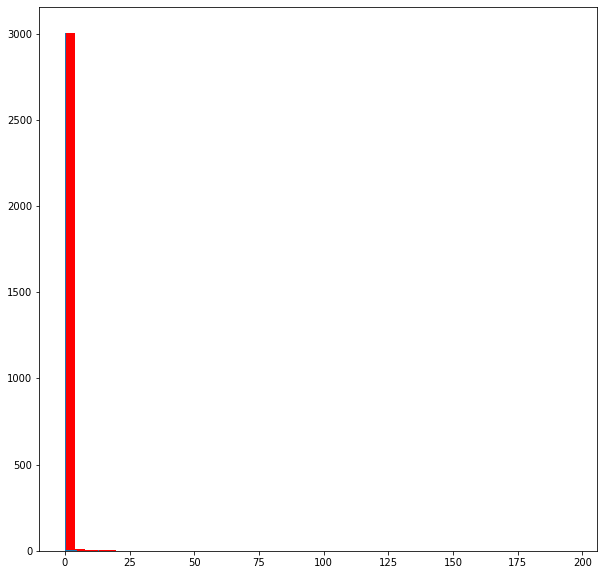

In [39]:
plt.figure(figsize=(10,10))
control_visit_all = df_new['REVENUE'][df_new['VARIANT_NAME']== 'control']

test_visit_all = df_new['REVENUE'][df_new['VARIANT_NAME']== 'variant']
plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all,  bins=50)
plt.show()




 Непараметрический критерий  Манн-Уитни

In [25]:
df_new.groupby('VARIANT_NAME')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,3026.0,0.155506,3.708620,0.0,0.0,0.0,0.0,196.01
variant,3044.0,0.058909,0.760344,0.0,0.0,0.0,0.0,23.04


In [28]:
list1 = df_new[(df_new['VARIANT_NAME'] == 'control')&(df_new['REVENUE'] > 0)]['REVENUE'].values
list1

array([2.3000e-01, 2.0070e+01, 2.1700e+00, 2.0100e+00, 1.2500e+00,
       4.3300e+00, 1.1980e+01, 8.6600e+00, 4.3300e+00, 1.5600e+00,
       1.4070e+01, 1.4240e+01, 5.8000e-01, 2.9320e+01, 1.0100e+00,
       9.9900e+00, 2.0200e+00, 1.8560e+01, 8.6600e+00, 8.6000e-01,
       1.9601e+02, 3.9900e+00, 1.0000e+00, 2.0000e-02, 3.2500e+00,
       2.1600e+00, 1.7050e+01, 4.3300e+00, 4.9800e+00, 2.0000e-02,
       4.5200e+00, 1.0100e+00, 4.8700e+00, 2.9900e+00, 6.3500e+00,
       4.0000e-02, 5.0000e-01, 1.0630e+01, 3.2500e+00, 2.9300e+00,
       1.7800e+00, 4.9500e+00, 2.6000e+00, 1.2500e+00, 1.2500e+00,
       9.9100e+00, 1.6600e+00, 2.1700e+00, 2.2200e+00, 2.9900e+00,
       4.2700e+00, 3.5800e+00, 2.3400e+00, 3.7900e+00])

In [29]:
len(list1)

54

In [30]:
list2 = df_new[(df_new['VARIANT_NAME'] == 'variant')&(df_new['REVENUE'] > 0)]['REVENUE'].values
list2

array([1.000e+00, 4.520e+00, 1.230e+00, 1.082e+01, 4.270e+00, 4.000e-02,
       1.947e+01, 5.980e+00, 6.000e-01, 2.720e+00, 3.750e+00, 3.830e+00,
       1.010e+00, 1.510e+00, 1.299e+01, 2.500e+00, 3.250e+00, 2.990e+00,
       7.270e+00, 3.980e+00, 1.299e+01, 3.280e+00, 3.750e+00, 3.000e+00,
       2.000e-02, 2.304e+01, 1.510e+00, 2.140e+00, 1.250e+00, 2.160e+00,
       1.750e+00, 4.270e+00, 9.000e-01, 8.700e+00, 6.000e-02, 1.250e+00,
       2.170e+00, 2.950e+00, 5.000e-01, 2.270e+00, 1.300e+00, 5.080e+00,
       1.250e+00])

In [31]:
len(list2)

43

Значений по apru > 0 очень мало, в контрольной группе 54, в тестовой 43

In [34]:
mw_stats = scipy.stats.mannwhitneyu(x=df_new[(df_new['VARIANT_NAME'] == 'control')&(df_new['REVENUE'] > 0)]['REVENUE'].values,
                                                  y=df_new[(df_new['VARIANT_NAME'] == 'variant')&(df_new['REVENUE'] > 0)]['REVENUE'].values)

In [37]:
alpha = 0.05
mw_stats

MannwhitneyuResult(statistic=1292.0, pvalue=0.3431833825117172)

Критерий МАНН_УИТНИ не позволяет принять альтернативную гипотезу о разнице apru.

In [40]:
from scipy.stats import shapiro

In [41]:
st = shapiro(df_new.REVENUE)
st

ShapiroResult(statistic=0.015946388244628906, pvalue=0.0)

In [42]:
print('Distribution is {}normal\n'.format( {True:'not ', False:''}[st[1] < alpha]));

Distribution is not normal



In [46]:
control = df_new.query('VARIANT_NAME == "control"')

test = df_new.query('VARIANT_NAME == "variant"')
len(control)

3026

In [47]:
len(test)

3044

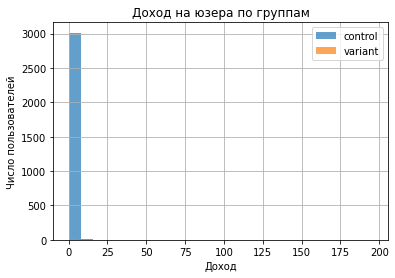

In [48]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='variant')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

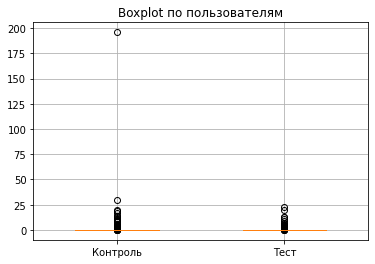

In [49]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [50]:
control.REVENUE

9892    0.0
6263    0.0
8030    0.0
7939    0.0
4874    0.0
       ... 
1755    0.0
1848    0.0
3260    0.0
9290    0.0
1064    0.0
Name: REVENUE, Length: 3026, dtype: float64

Для интереса применим Т-тест. Хотя выборка не обладает нормальным распределением.

In [51]:
scipy.stats.stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.4037622523716748, pvalue=0.16048440176908432)

Т-тест также не позволяет принять альтернативную гипотезу о разнице apru.

In [52]:
control[control['REVENUE'] > 0];

In [53]:
test[test['REVENUE'] > 0];

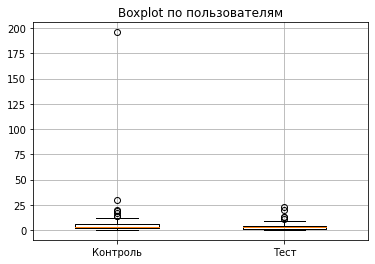

In [54]:
plt.boxplot([control[control['REVENUE'] > 0].REVENUE,test[test['REVENUE'] > 0].REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5)
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

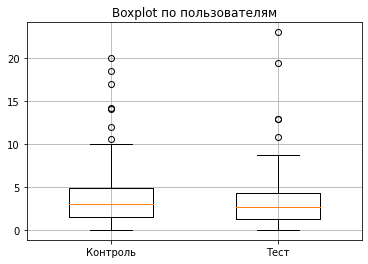

In [55]:
plt.boxplot([control[(control['REVENUE'] > 0) & (control['REVENUE'] < 25)].REVENUE,test[(test['REVENUE'] > 0) & (test['REVENUE'] < 25)].REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5)
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

Расчет мощности

d = (M1 – M2) / S_pooled

S_pooled =

In [57]:
C_mean = control.REVENUE.values.mean()

T_mean = test.REVENUE.values.mean()


C_std = control.REVENUE.values.std()

T_std = test.REVENUE.values.std()

In [58]:
print(len(control.REVENUE.values), len(test.REVENUE.values))

3026 3044


In [59]:
n =  len(control.REVENUE.values)

In [60]:
S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [61]:
effect =float((T_mean-C_mean)/ S) 

In [62]:
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis

alpha = 0.05

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=None,
nobs1=n, ratio=1.0, alpha=alpha)

result

0.28936707257547534